In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

# Supervised
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Unsupervised
# from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

In [3]:
dataset = pd.read_parquet('../Dataset/cic-collection.parquet')

In [4]:
# --- Print Shape ---
print("\nDataset Shape (Rows, Columns):")
print(dataset.shape)

# --- Print Data Types and Non-Null Counts (very useful) ---
print("\nDataset Info (Column dtypes and non-null counts):")
dataset.info()

# --- Print First Few Rows (for a visual check) ---
print("\nFirst 5 rows of the Dataset:")
print(dataset.head())

# --- Print Column Names ---
print("\nColumn Names:")
print(dataset.columns.tolist())

# --- Print Basic Descriptive Statistics (for numerical columns) ---
print("\nDescriptive Statistics:")
print(dataset.describe())


Dataset Shape (Rows, Columns):
(9167581, 59)

Dataset Info (Column dtypes and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9167581 entries, 0 to 9167580
Data columns (total 59 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Flow Duration             int64  
 1   Total Fwd Packets         int32  
 2   Total Backward Packets    int32  
 3   Fwd Packets Length Total  float64
 4   Bwd Packets Length Total  float64
 5   Fwd Packet Length Max     float64
 6   Fwd Packet Length Mean    float32
 7   Fwd Packet Length Std     float32
 8   Bwd Packet Length Max     float64
 9   Bwd Packet Length Mean    float32
 10  Bwd Packet Length Std     float32
 11  Flow Bytes/s              float64
 12  Flow Packets/s            float64
 13  Flow IAT Mean             float32
 14  Flow IAT Std              float32
 15  Flow IAT Max              float64
 16  Flow IAT Min              float64
 17  Fwd IAT Total             float64
 18  Fwd I

# DATA VISUALIZATION

C:\Users\ambar\AppData\Local\Temp\ipykernel_3320\3407807541.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dtype_counts.values, y=dtype_counts.index, palette='viridis', ax=axes[0])


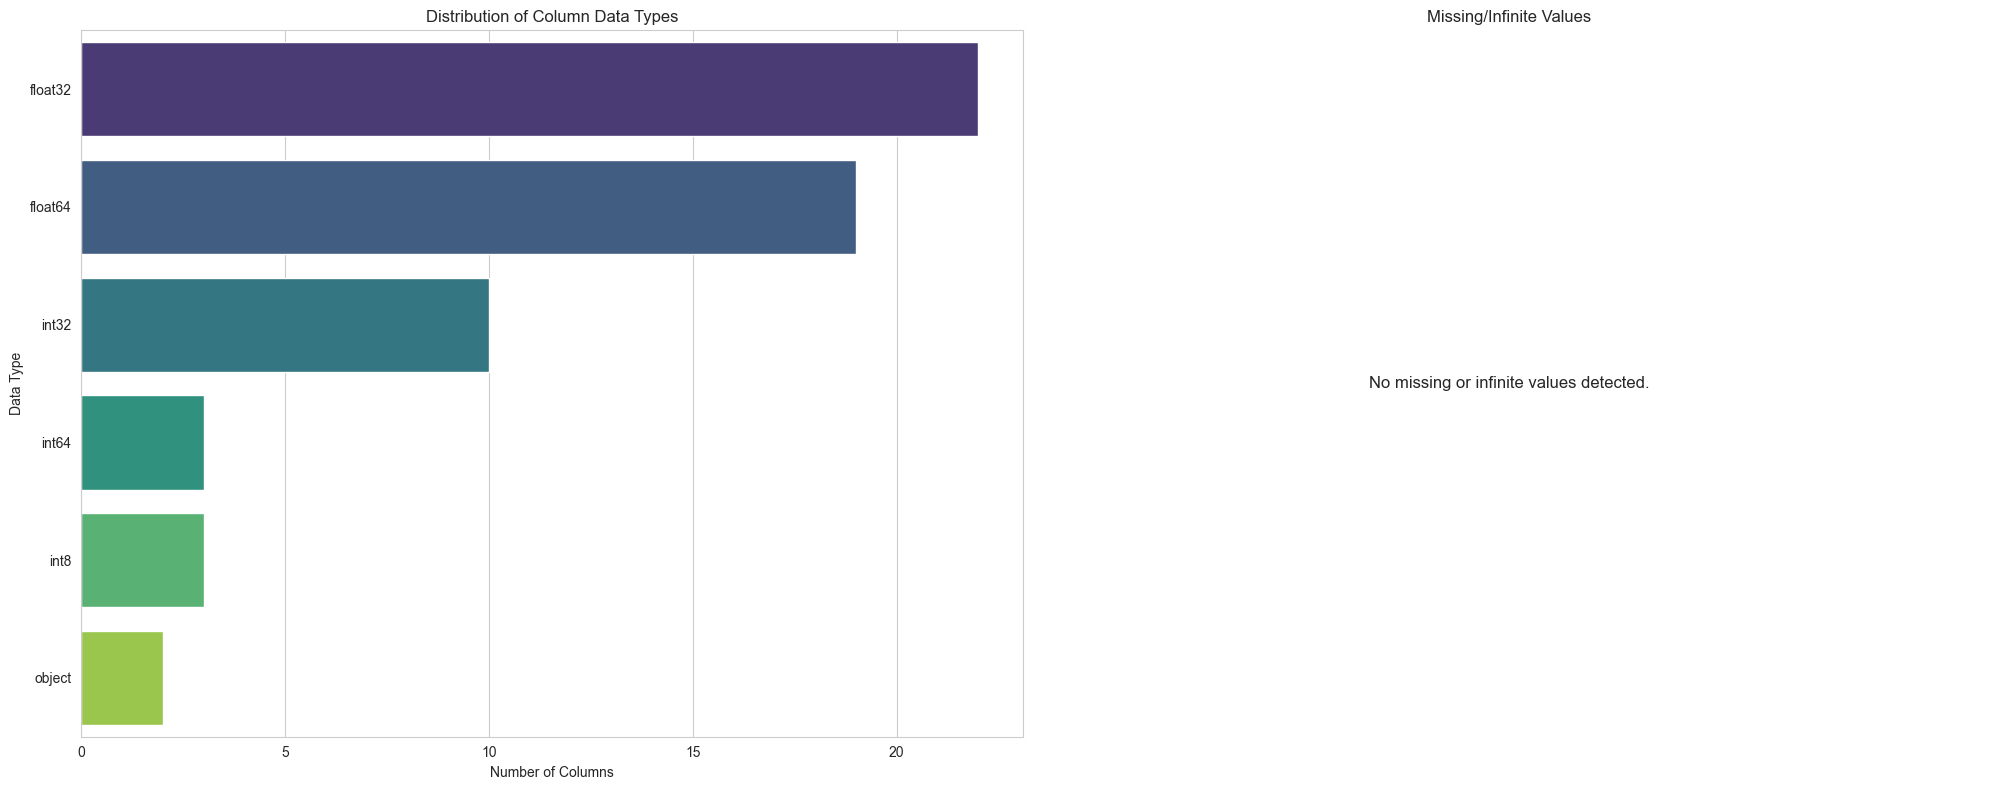

C:\Users\ambar\AppData\Local\Temp\ipykernel_3320\3407807541.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Label', data=dataset, order=dataset['Label'].value_counts().index, palette='tab10', ax=axes[plot_idx])
C:\Users\ambar\AppData\Local\Temp\ipykernel_3320\3407807541.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='ClassLabel', data=dataset, order=dataset['ClassLabel'].value_counts().index, palette='pastel', ax=axes[plot_idx])


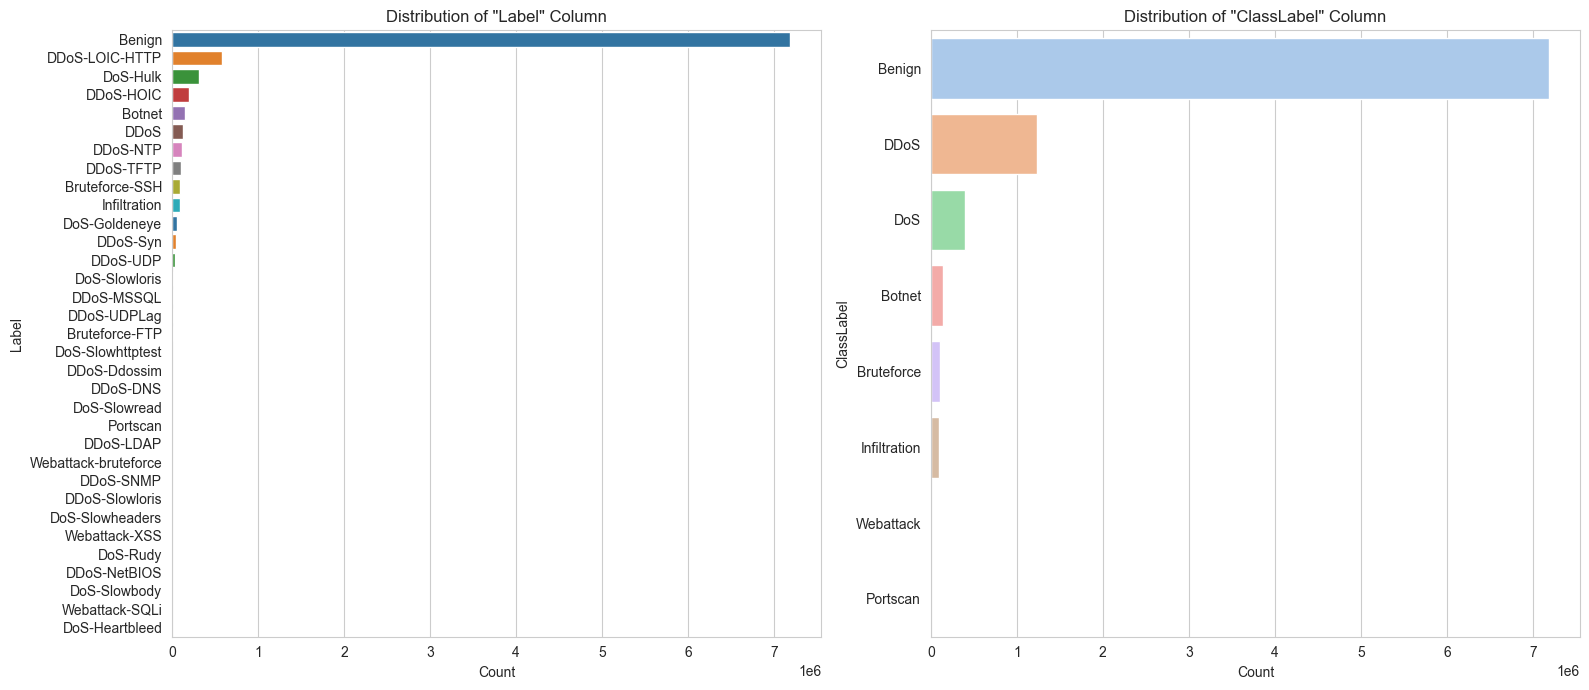

c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


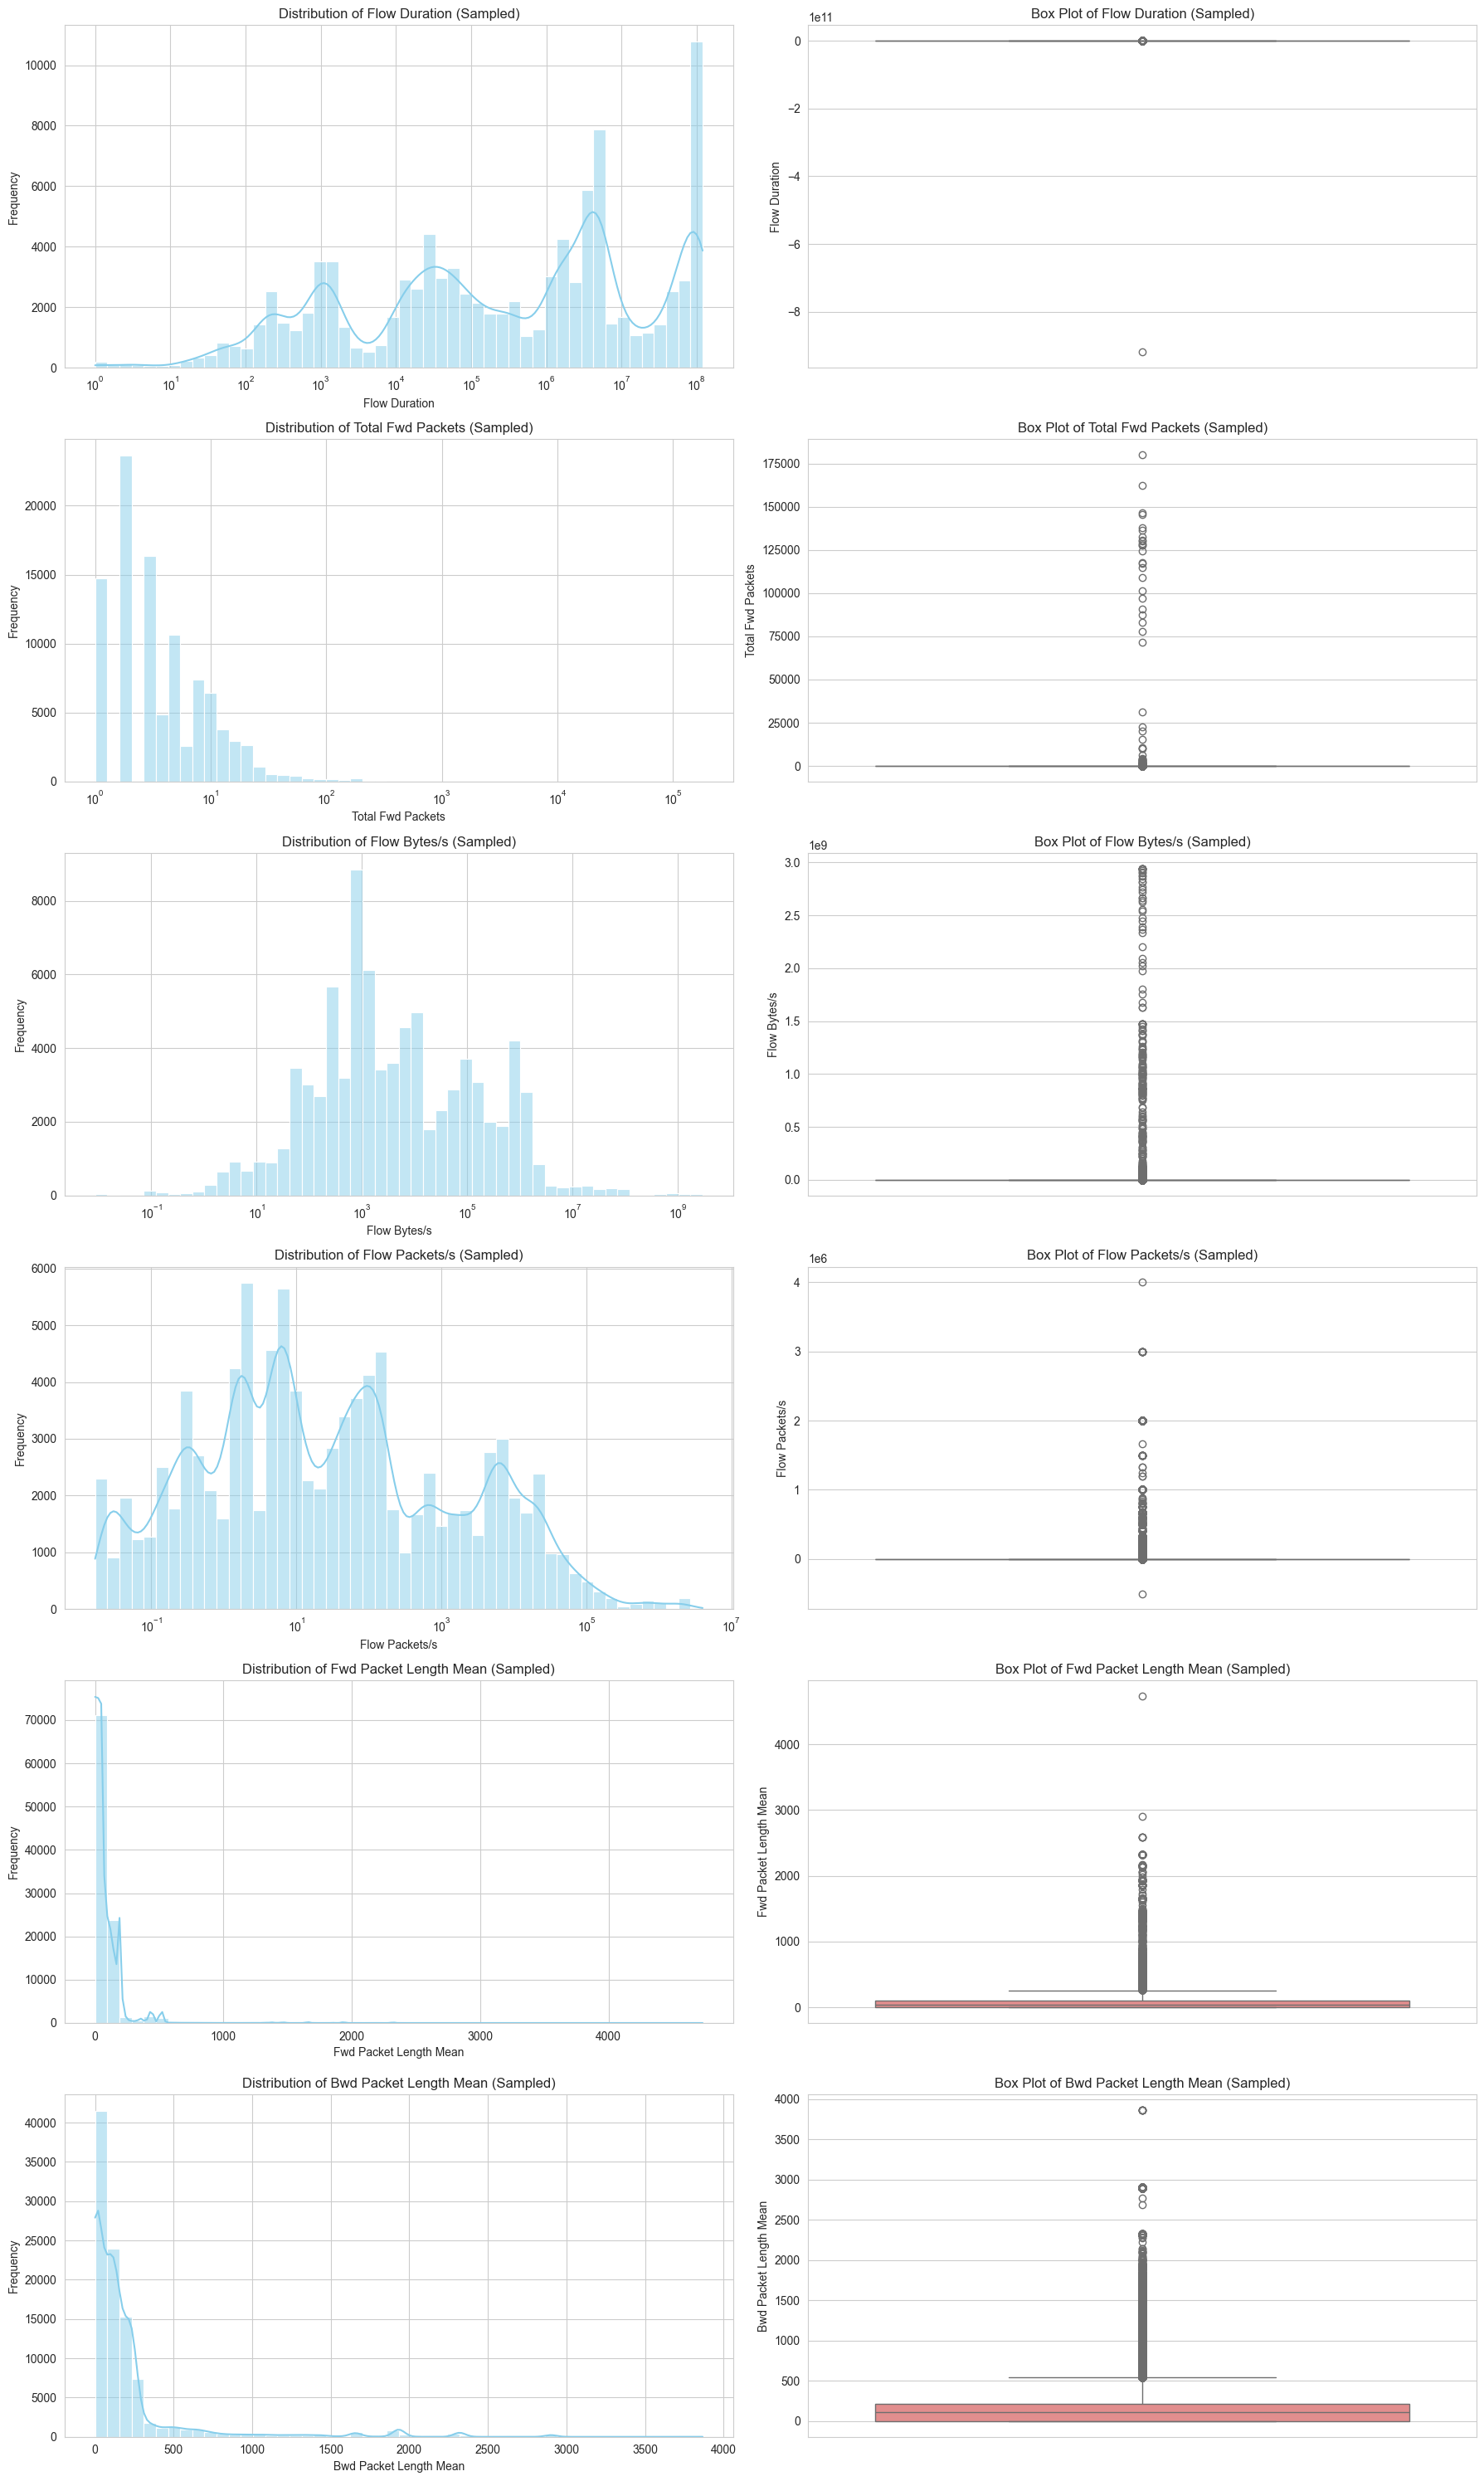


Computing correlation matrix (sampling data for performance)...


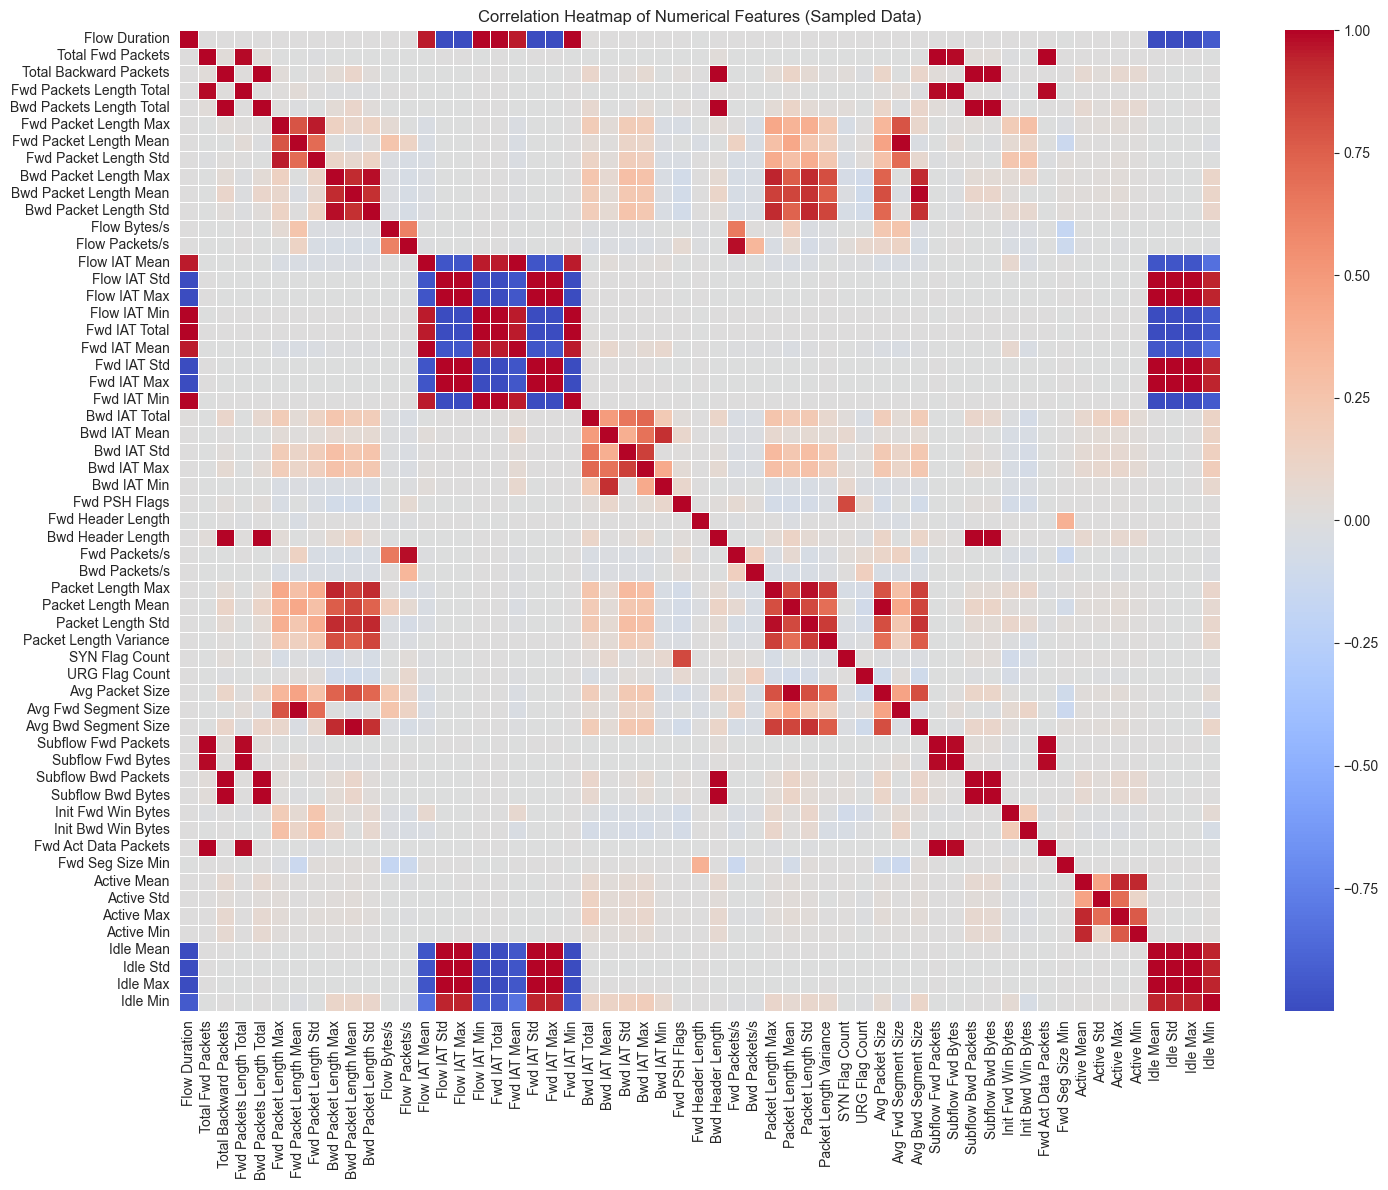

In [5]:
# Set general plot style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15, 8) # A reasonable default for many plots

# --- 1. Visualization of Data Types and Missing/Infinite Values ---

# 1.1 Get Data Type Counts
dtype_counts = dataset.dtypes.astype(str).value_counts()

# 1.2 Get Missing Values
missing_data = dataset.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

# 1.3 Get Infinite Values (sampling for performance on large datasets)
numerical_cols = dataset.select_dtypes(include=np.number).columns
infinite_counts = {}
if not numerical_cols.empty:
    sample_size = min(100000, len(dataset))
    sample_df = dataset[numerical_cols].sample(n=sample_size, random_state=42)
    for col in numerical_cols:
        inf_count = np.isinf(sample_df[col]).sum()
        if inf_count > 0:
            infinite_counts[col] = inf_count
    infinite_data = pd.Series(infinite_counts).sort_values(ascending=False)
else:
    infinite_data = pd.Series([])

# Combine missing and infinite for a comprehensive "bad data" view
all_bad_data = pd.concat([missing_data, infinite_data]).drop_duplicates().sort_values(ascending=False)


# Create subplots for Data Types and Missing/Infinite Values
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Subplot 1: Data Type Distribution
sns.barplot(x=dtype_counts.values, y=dtype_counts.index, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Column Data Types')
axes[0].set_xlabel('Number of Columns')
axes[0].set_ylabel('Data Type')

# Subplot 2: Columns with Missing or Infinite Values
if not all_bad_data.empty:
    sns.barplot(x=all_bad_data.values, y=all_bad_data.index, palette='Reds_d', ax=axes[1])
    axes[1].set_title('Columns with Missing or Infinite Values (Sampled for Infinities)')
    axes[1].set_xlabel('Count of Missing/Infinite Values')
    axes[1].set_ylabel('Column Name')
else:
    axes[1].text(0.5, 0.5, "No missing or infinite values detected.", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Missing/Infinite Values')
    axes[1].axis('off') # Hide axes if no data

plt.tight_layout()
plt.show()


# --- 2. Visualization of Target Variable Distributions ---

# Determine how many subplots needed for target variables
num_target_plots = 0
if 'Label' in dataset.columns:
    num_target_plots += 1
if 'ClassLabel' in dataset.columns and 'ClassLabel' != 'Label': # Avoid plotting same column twice if accidentally named same
    num_target_plots += 1

if num_target_plots > 0:
    fig, axes = plt.subplots(1, num_target_plots, figsize=(8 * num_target_plots, 7))
    # Ensure 'axes' is an array even if only one subplot
    if num_target_plots == 1:
        axes = [axes] # Make it a list so we can iterate

    plot_idx = 0
    if 'Label' in dataset.columns:
        sns.countplot(y='Label', data=dataset, order=dataset['Label'].value_counts().index, palette='tab10', ax=axes[plot_idx])
        axes[plot_idx].set_title('Distribution of "Label" Column')
        axes[plot_idx].set_xlabel('Count')
        axes[plot_idx].set_ylabel('Label')
        plot_idx += 1

    if 'ClassLabel' in dataset.columns and 'ClassLabel' != 'Label':
        sns.countplot(y='ClassLabel', data=dataset, order=dataset['ClassLabel'].value_counts().index, palette='pastel', ax=axes[plot_idx])
        axes[plot_idx].set_title('Distribution of "ClassLabel" Column')
        axes[plot_idx].set_xlabel('Count')
        axes[plot_idx].set_ylabel('ClassLabel')
        plot_idx += 1

    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'Label' or 'ClassLabel' columns found for distribution plotting.")


# --- 3. Visualization of Distributions for Key Numerical Features ---

# Select a few key numerical features to plot distributions
# You can adjust this list based on what you find most interesting from dataset.describe()
numerical_features_to_plot = [
    'Flow Duration',
    'Total Fwd Packets',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean'
]

# Filter to ensure chosen columns exist and are numerical
numerical_features_to_plot = [col for col in numerical_features_to_plot if col in dataset.columns and np.issubdtype(dataset[col].dtype, np.number)]

if numerical_features_to_plot:
    # We'll plot two types of charts (histogram/KDE and box plot) for each feature
    # So, rows = number of features, columns = 2
    n_features = len(numerical_features_to_plot)
    n_cols_per_feature = 2 # One for hist/kde, one for boxplot
    n_rows = n_features

    fig, axes = plt.subplots(n_rows, n_cols_per_feature, figsize=(18, 5 * n_rows))

    # Flatten axes array for easy iteration if more than one row
    if n_rows > 1:
        axes = axes.flatten()
    else: # If only one row (one feature), axes might not be an array
        axes = axes # No flattening needed if it's already 1D or single

    for i, col in enumerate(numerical_features_to_plot):
        # Create a sample for plotting very large numerical datasets
        # Plotting millions of points can be slow and memory intensive
        sample_for_plot = dataset[col].sample(n=min(100000, len(dataset)), random_state=42)

        # Histogram/KDE plot
        current_ax_hist = axes[i * n_cols_per_feature]
        sns.histplot(sample_for_plot, kde=True, bins=50,
                     log_scale=True if any(keyword in col.lower() for keyword in ['flow', 'total', 'bytes', 'packets', 'duration']) else False,
                     color='skyblue', ax=current_ax_hist)
        current_ax_hist.set_title(f'Distribution of {col} (Sampled)')
        current_ax_hist.set_xlabel(col)
        current_ax_hist.set_ylabel('Frequency')

        # Box plot
        current_ax_box = axes[i * n_cols_per_feature + 1]
        sns.boxplot(y=sample_for_plot, color='lightcoral', ax=current_ax_box)
        current_ax_box.set_title(f'Box Plot of {col} (Sampled)')
        current_ax_box.set_ylabel(col)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo relevant numerical features found for detailed distribution plotting.")


# --- 4. Correlation Heatmap (for numerical features) ---
# This can be very slow for many columns, so we'll sample the dataset
# and then compute correlation. Also, plotting 57x57 heatmap is unreadable.
# Select a subset of numerical columns for correlation, or apply a threshold.

numerical_cols_for_corr = dataset.select_dtypes(include=np.number).columns.tolist()

if len(numerical_cols_for_corr) > 1: # Need at least two numerical columns for correlation
    print("\nComputing correlation matrix (sampling data for performance)...")
    # Sample a smaller DataFrame for correlation calculation
    # Adjust sample size if needed, but 50k-100k is often sufficient for correlation patterns
    correlation_sample_size = min(50000, len(dataset))
    sampled_df_for_corr = dataset[numerical_cols_for_corr].sample(n=correlation_sample_size, random_state=42)

    # Compute correlation matrix
    corr_matrix = sampled_df_for_corr.corr()

    # Optional: Filter for highly correlated features if too many columns
    # high_corr_cols = corr_matrix[(corr_matrix > 0.8) | (corr_matrix < -0.8)].dropna(how='all').index.tolist()
    # if len(high_corr_cols) > 1 and len(high_corr_cols) < len(numerical_cols_for_corr):
    #     corr_matrix = corr_matrix.loc[high_corr_cols, high_corr_cols]
    #     print(f"Showing correlation for {len(high_corr_cols)} highly correlated features.")

    plt.figure(figsize=(15, 12)) # Adjust size based on number of columns
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Numerical Features (Sampled Data)')
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough numerical columns to compute a correlation heatmap.")

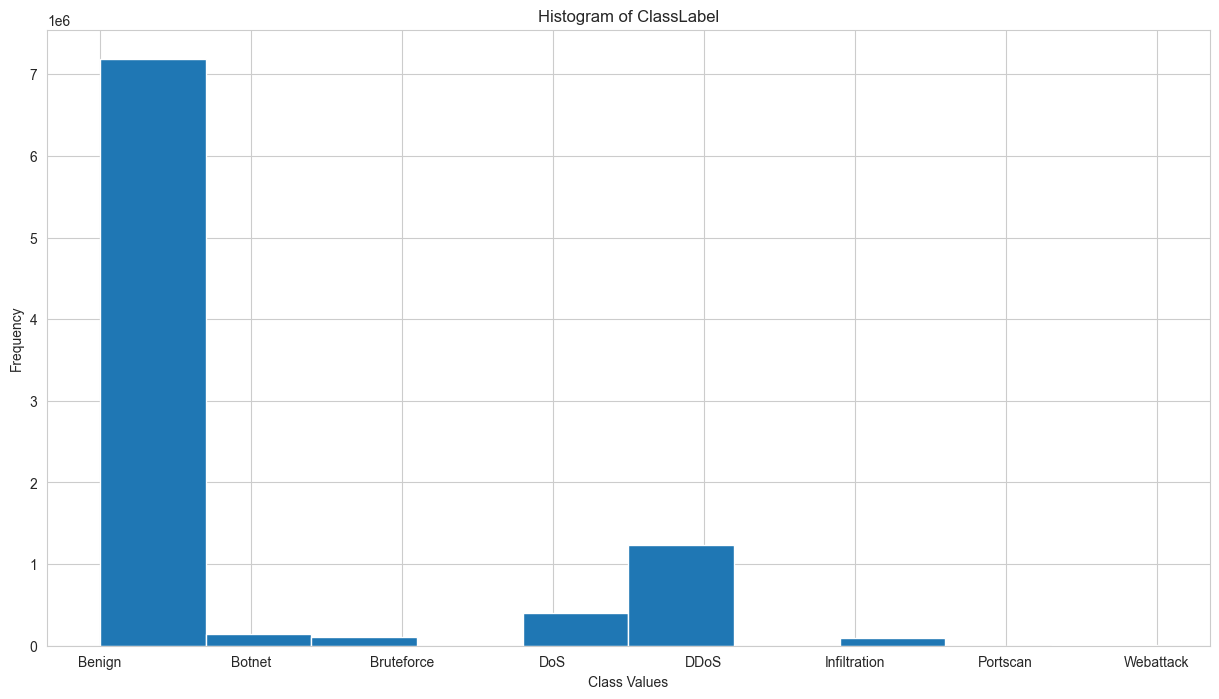

Frequency of each ClassLabel:
Class 'Benign': 7186189
Class 'DDoS': 1234729
Class 'DoS': 397344
Class 'Botnet': 145968
Class 'Bruteforce': 103244
Class 'Infiltration': 94857
Class 'Webattack': 2995
Class 'Portscan': 2255


In [6]:
# Create the histogram
plt.hist(dataset['ClassLabel'])

# Add labels and title
plt.xlabel('Class Values')
plt.ylabel('Frequency')
plt.title('Histogram of ClassLabel')

# Show the plot
plt.show()

# Calculate the frequency of each unique value in 'ClassLabel'
class_frequencies = dataset['ClassLabel'].value_counts()

# Print the frequency for each class label
print("Frequency of each ClassLabel:")
for label, frequency in class_frequencies.items():
    print(f"Class '{label}': {frequency}")

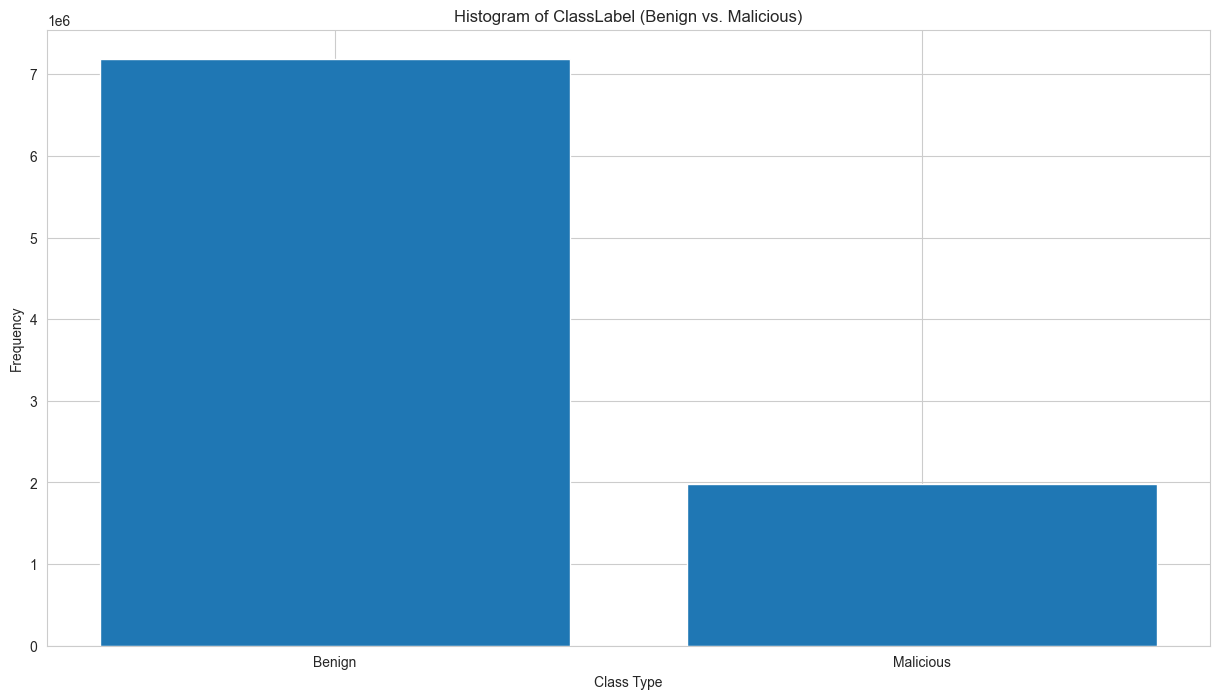

ClassLabel
0    7186189
1    1981392
Name: count, dtype: int64


In [7]:
# make a copy so we don’t touch the original
full_data = dataset.drop(columns=['Label'])

# map ClassLabel to 0/1
full_data['ClassLabel'] = full_data['ClassLabel'].apply(lambda x: 0 if x == 'Benign' else 1)

plt.hist(full_data['ClassLabel'], bins=[0, 1, 2], align='left', rwidth=0.8)

plt.xticks([0, 1], ['Benign', 'Malicious'])

plt.xlabel('Class Type')
plt.ylabel('Frequency')
plt.title('Histogram of ClassLabel (Benign vs. Malicious)')

# Show the plot
plt.show()

# verify the transformation
print(full_data['ClassLabel'].value_counts())

In [8]:
# 1. Separate features and target
inputs = full_data.drop(columns=['ClassLabel'])
labels = full_data['ClassLabel']

# 2. Perform stratified train/test split
train_data, test_data, train_label, test_label = train_test_split(inputs, labels, test_size=0.20, stratify=labels, random_state=42)

print(f"Training Data:{len(train_data)}, Testing Data:{len(test_data)}")

Training Data:7334064, Testing Data:1833517


# MODEL

In [16]:
this block makes ensures that the next blocks for models doesn't run again and loose all the progress and useful insights

SyntaxError: unterminated string literal (detected at line 1) (1420481667.py, line 1)

LOGISTIC REGRESSION

c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78   1437238
           1       0.14      0.13      0.14    396279

    accuracy                           0.64   1833517
   macro avg       0.45      0.46      0.46   1833517
weighted avg       0.63      0.64      0.64   1833517



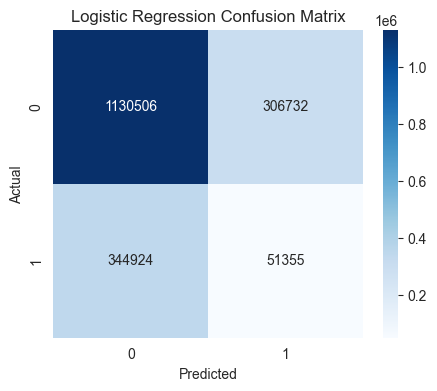

In [11]:
# 1. Initialize model (no regularization)
lr = LogisticRegression(penalty='none', solver='saga', max_iter=100, random_state=42)
# 10 takes 3 mins, recommended 1000
# 100 takes 17 mins, recommended 1000
# Result of each are same

# 2. Fit on training data
lr.fit(train_data, train_label)

# 3. Predict on test set
y_pred = lr.predict(test_data)

# 4. Print metrics
print("\nClassification Report:\n", classification_report(test_label, y_pred))

# 5. Plot confusion matrix
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

SUPPORT VECTOR MACHINE

c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=== Linear SVM ===
              precision    recall  f1-score   support

           0       0.81      0.99      0.89   1437238
           1       0.84      0.17      0.28    396279

    accuracy                           0.81   1833517
   macro avg       0.83      0.58      0.59   1833517
weighted avg       0.82      0.81      0.76   1833517



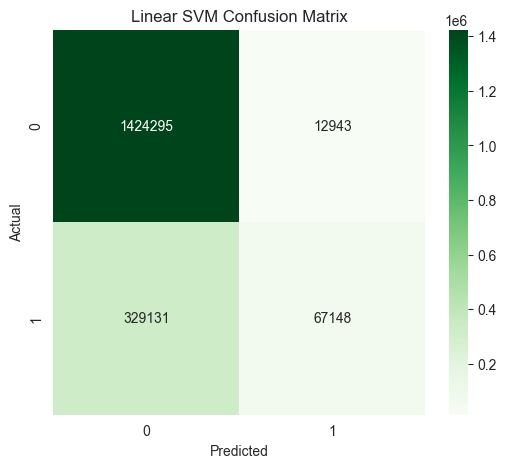

In [13]:
# 1. Instantiate & train Linear SVM
svm = LinearSVC(max_iter=10, random_state=42) # 10 takes 2 mins, reccomended 10000
svm.fit(train_data, train_label)

# 2. Predict on test set
y_pred = svm.predict(test_data)

# 3. Evaluation
print("=== Linear SVM ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear SVM Confusion Matrix')
plt.show()

c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=== Linear SVM ===
              precision    recall  f1-score   support

           0       0.80      0.78      0.79   1437238
           1       0.26      0.28      0.27    396279

    accuracy                           0.67   1833517
   macro avg       0.53      0.53      0.53   1833517
weighted avg       0.68      0.67      0.68   1833517



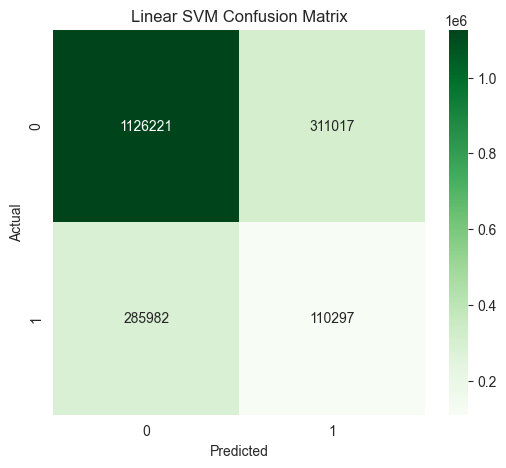

In [14]:
# 1. Instantiate & train Linear SVM
svm = LinearSVC(max_iter=1000, random_state=42)
# 10 takes 2 mins, recommended 10000
# 100 takes 10 mins, recommened 10000
# result beacme worse
# 1000 takes 86 mins, recommended 10000
# became worse

svm.fit(train_data, train_label)

# 2. Predict on test set
y_pred = svm.predict(test_data)

# 3. Evaluation
print("=== Linear SVM ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear SVM Confusion Matrix')
plt.show()

K-NEAREST NEIGHBORS

In [1]:
# Not performed as it's lazy learning

'''
For every single point in your test set (1,833,517 samples), the algorithm must calculate its distance to every single point in your training set (7,334,064 samples).

This means approximately 1.8 million * 7.3 million distance calculations. That's about 13 trillion (1.3 x 10^13) individual distance computations.
'''

'''
# 1. Instantiate & train k-NN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Ensure training data is a contiguous NumPy array
X_train = np.ascontiguousarray(train_data.to_numpy(), dtype=np.float32)
y_train = train_label.to_numpy()  # Ensure labels are also NumPy

knn.fit(X_train, y_train)

# 2. Prepare test data
X_test = np.ascontiguousarray(test_data.to_numpy(), dtype=np.float32)
y_test = test_label.to_numpy()

# 3. Predict
y_pred = knn.predict(X_test)

# 4. Evaluation
print("=== k-Nearest Neighbors (k=5) ===")
print(classification_report(y_test, y_pred))

# 5. Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()
'''

'\n# 1. Instantiate & train k-NN\nknn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)\n\n# Ensure training data is a contiguous NumPy array\nX_train = np.ascontiguousarray(train_data.to_numpy(), dtype=np.float32)\ny_train = train_label.to_numpy()  # Ensure labels are also NumPy\n\nknn.fit(X_train, y_train)\n\n# 2. Prepare test data\nX_test = np.ascontiguousarray(test_data.to_numpy(), dtype=np.float32)\ny_test = test_label.to_numpy()\n\n# 3. Predict\ny_pred = knn.predict(X_test)\n\n# 4. Evaluation\nprint("=== k-Nearest Neighbors (k=5) ===")\nprint(classification_report(y_test, y_pred))\n\n# 5. Confusion matrix plot\ncm = confusion_matrix(y_test, y_pred)\nplt.figure(figsize=(6,5))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Oranges\',\n            xticklabels=[0,1], yticklabels=[0,1])\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'k-NN Confusion Matrix\')\nplt.show()\n'

DECISION TREE

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1437238
           1       1.00      0.95      0.97    396279

    accuracy                           0.99   1833517
   macro avg       0.99      0.97      0.98   1833517
weighted avg       0.99      0.99      0.99   1833517



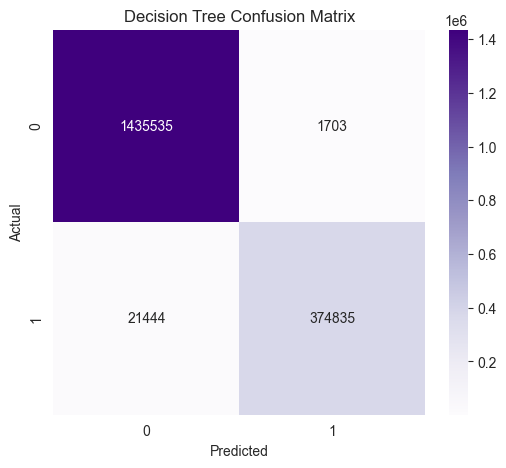

In [8]:
# 1. Instantiate & train Decision Tree
dt = DecisionTreeClassifier(max_depth=15, min_samples_leaf=500, random_state=42) # 15, 500 takes 15 mins
dt.fit(train_data, train_label)

# 2. Predict on test set
y_pred = dt.predict(test_data)

# 3. Evaluation
print("=== Decision Tree ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

RANDOM FOREST

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1437238
           1       0.99      0.94      0.96    396279

    accuracy                           0.98   1833517
   macro avg       0.99      0.97      0.98   1833517
weighted avg       0.98      0.98      0.98   1833517



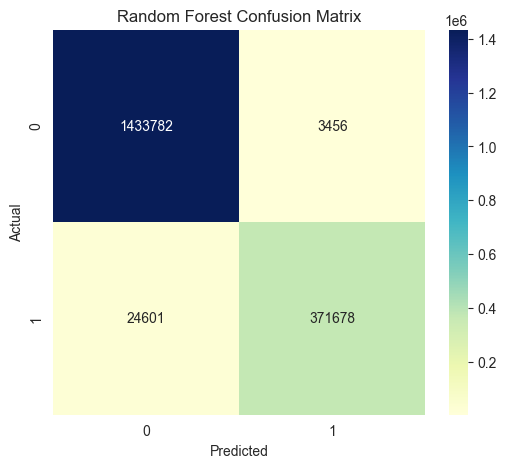

In [10]:
# 1. Instantiate & train Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=500, n_jobs=-1, random_state=42) # 50, 15, 500 takes 24 mins
rf.fit(train_data, train_label)

# 2. Predict on test set
y_pred = rf.predict(test_data)

# 3. Evaluation
print("=== Random Forest ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

XGBOOST

c:\Users\ambar\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Classifier ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1437238
           1       1.00      0.95      0.97    396279

    accuracy                           0.99   1833517
   macro avg       0.99      0.98      0.98   1833517
weighted avg       0.99      0.99      0.99   1833517



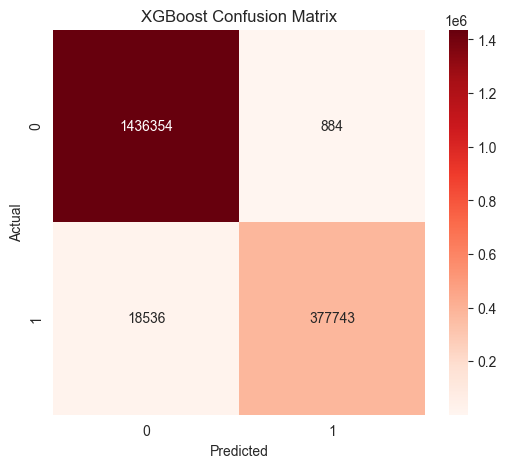

In [14]:
# 1. Instantiate & train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=50, max_depth=15, n_jobs=-1)
# log_loss, 30, 8, 0.1, 0.8, 0.8 takes 48s
# log_loss, 50, 15, 0.1, 0.8, 0.8 takes 2 mins
xgb.fit(train_data, train_label)

# 2. Predict on test set
y_pred = xgb.predict(test_data)

# 3. Evaluation
print("=== XGBoost Classifier ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

LIGHTGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1585113, number of negative: 5748951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.301407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13546
[LightGBM] [Info] Number of data points in the train set: 7334064, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216130 -> initscore=-1.288362
[LightGBM] [Info] Start training from score -1.288362
=== LightGBM Classifier ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1437238
           1       1.00      0.95      0.97    396279

    accuracy                           0.99   1833517
   macro avg       0.99      0.97      0.98   1833517
weighted avg       0.99      0.99      0.99   1833517



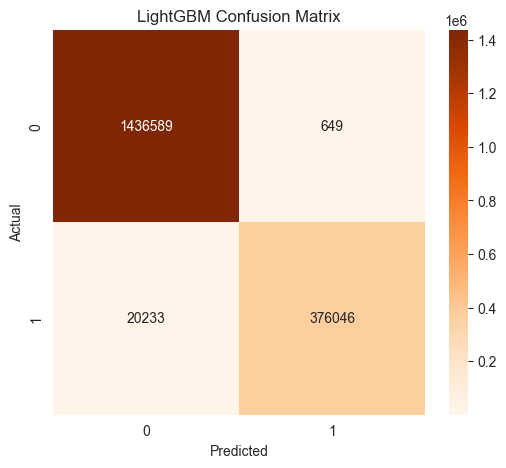

In [21]:
# 1. Instantiate & train LightGBM
lgbm = LGBMClassifier(n_estimators=50, max_depth=15, num_leaves=64,subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1) # 50, 15 takes 1 min
lgbm.fit(train_data, train_label)

# 2. Predict on test set
y_pred = lgbm.predict(test_data)

# 3. Evaluation
print("=== LightGBM Classifier ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM Confusion Matrix')
plt.show()

GAUSSIAN NAIVE BAYES

=== Gaussian Naive Bayes ===
              precision    recall  f1-score   support

           0       0.94      0.05      0.09   1437238
           1       0.22      0.99      0.36    396279

    accuracy                           0.25   1833517
   macro avg       0.58      0.52      0.23   1833517
weighted avg       0.78      0.25      0.15   1833517



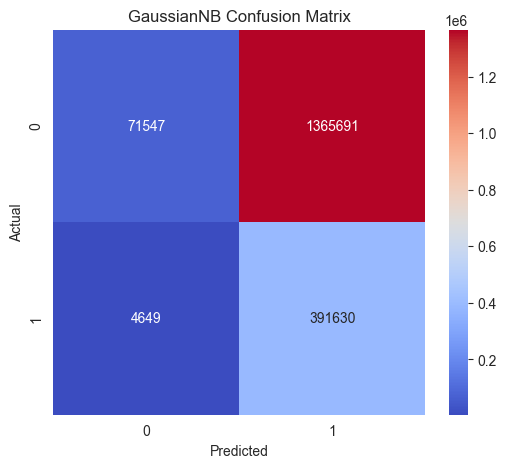

In [24]:
# 1. Instantiate & train GaussianNB
gnb = GaussianNB()
gnb.fit(train_data, train_label)

# 2. Predict on test set
y_pred = gnb.predict(test_data)

# 3. Evaluation
print("=== Gaussian Naive Bayes ===")
print(classification_report(test_label, y_pred))

# 4. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GaussianNB Confusion Matrix')
plt.show()

MULTIMODAL NAIVE BAYES

=== Multinomial Naive Bayes ===
              precision    recall  f1-score   support

           0       0.78      1.00      0.88   1437238
           1       0.98      0.00      0.00    396279

    accuracy                           0.78   1833517
   macro avg       0.88      0.50      0.44   1833517
weighted avg       0.83      0.78      0.69   1833517



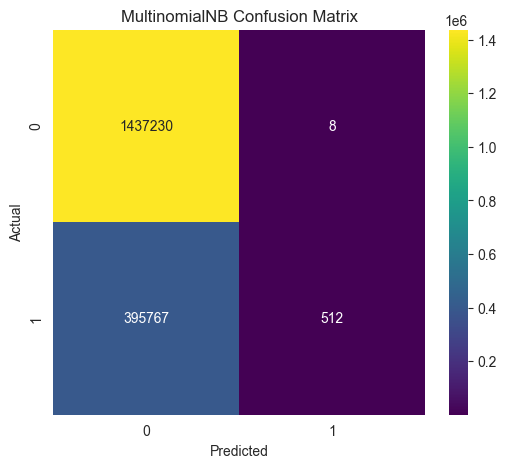

In [28]:
# 1. Scale features to [0,1] (required for MultinomialNB)
scaler = MinMaxScaler() # Must scale to handle negative features
X_train_scaled = scaler.fit_transform(train_data)
X_test_scaled  = scaler.transform(test_data)

# 2. Instantiate & train MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_scaled, train_label)

# 3. Predict on test set
y_pred = mnb.predict(X_test_scaled)

# 4. Evaluation
print("=== Multinomial Naive Bayes ===")
print(classification_report(test_label, y_pred))

# 5. Confusion matrix plot
cm = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MultinomialNB Confusion Matrix')
plt.show()

ONE-CLASS SUPPORT VECTOR MACHINE

In [17]:
# Not performed as it's The computational complexity for standard SVMs (including One-Class SVMs) is typically in the range of O(n^2) to O(n^3), where 'n' is the number of training samples.

'''
# 1. Train on benign samples only
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(train_data[train_label == 0])

# 2. Predict on test set
#  +1 → inlier (benign), -1 → outlier (malicious)
raw_pred = ocsvm.predict(test_data)
ocsvm_pred = [0 if p == 1 else 1 for p in raw_pred]

# 3. Print performance
print("=== One-Class SVM ===")
print(classification_report(test_label, ocsvm_pred))

# 4. Plot confusion matrix
cm = confusion_matrix(test_label, ocsvm_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('One-Class SVM Confusion Matrix')
plt.show()
'''

ISOLATION FOREST

Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0     0.8052    0.7707    0.7876   1437238
           1     0.2803    0.3239    0.3005    396279

    accuracy                         0.6741   1833517
   macro avg     0.5428    0.5473    0.5441   1833517
weighted avg     0.6918    0.6741    0.6823   1833517



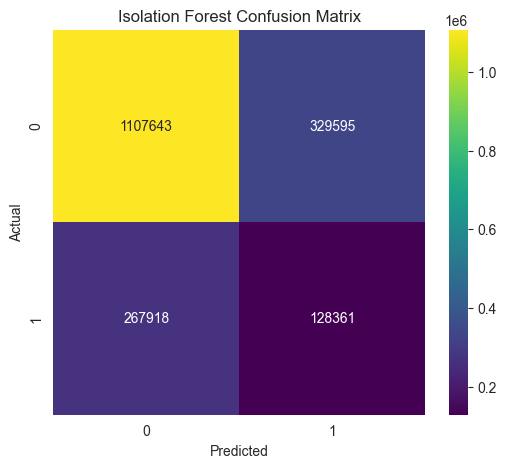

In [18]:
# 1) Fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.25, random_state=42, n_jobs=-1)
iso_forest.fit(train_data)

# 2) Predict: +1 = inlier (normal), -1 = outlier (anomaly)
y_pred_if = iso_forest.predict(test_data)
y_pred_if = (y_pred_if == -1).astype(int)     # 1=anomaly, 0=normal
y_true = (test_label == 1).astype(int)        # adjust if anomaly label ≠ 1

# 3) Classification metrics
print("Isolation Forest Classification Report:")
print(classification_report(y_true, y_pred_if, digits=4))

# 4) Confusion matrix plot
cm_if = confusion_matrix(y_true, y_pred_if)
plt.figure(figsize=(6,5))
sns.heatmap(cm_if, annot=True, fmt='d', cmap='viridis',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Isolation Forest Confusion Matrix')
plt.show()

LOCAL OUTLIER FACTOR

In [ ]:
# Not performed as it's lazy learning

'''

# 1) Fit LOF in novelty detection mode
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(train_data)

# 2) Predict: +1 = inlier (normal), -1 = outlier (anomaly)
y_pred_lof = lof.predict(test_data)
y_pred_lof = (y_pred_lof == -1).astype(int)    # convert: 1=anomaly, 0=normal
y_true = (test_label == 1).astype(int)         # adjust if anomaly label ≠ 1

# 3) Classification metrics
print("LOF Classification Report:")
print(classification_report(y_true, y_pred_lof, digits=4))

# 4) Confusion matrix plot with seaborn
cm_lof = confusion_matrix(y_true, y_pred_lof)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lof, annot=True, fmt='d', cmap='viridis',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Local Outlier Factor Confusion Matrix')
plt.show()

'''

DBSCAN

In [ ]:
# May take several hours

'''

# 1) Fit DBSCAN on the TEST data for anomaly detection
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
y_db_labels = dbscan.fit_predict(test_data)

# 2) Convert DBSCAN labels: -1 = noise (anomaly), others = cluster IDs (normal)
y_pred_db = (y_db_labels == -1).astype(int)   # 1=anomaly, 0=normal
y_true = (test_label == 1).astype(int)        # adjust if anomaly label ≠ 1

# 3) Classification metrics
print("DBSCAN Classification Report:")
print(classification_report(y_true, y_pred_db, digits=4))

# 4) Confusion matrix with seaborn
cm_db = confusion_matrix(y_true, y_pred_db)
plt.figure(figsize=(6,5))
sns.heatmap(cm_db, annot=True, fmt='d', cmap='viridis',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DBSCAN Confusion Matrix')
plt.show()

'''


In [8]:
# Use PCA

# 1) Scale + PCA → 10 dims
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_data)
pca    = PCA(n_components=10, random_state=42)
X_red  = pca.fit_transform(X_scaled)

# 2) DBSCAN on reduced data
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
y_db_labels = dbscan.fit_predict(X_red)

# 3) Convert labels & evaluate
y_pred_db = (y_db_labels == -1).astype(int)
y_true    = (test_label == 1).astype(int)

# 3) Classification metrics
print("DBSCAN Classification Report:")
print(classification_report(y_true, y_pred_db, digits=4))

# 4) Confusion matrix with seaborn
cm_db = confusion_matrix(y_true, y_pred_db)
plt.figure(figsize=(6,5))
sns.heatmap(cm_db, annot=True, fmt='d', cmap='viridis',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DBSCAN Confusion Matrix')
plt.show()

MemoryError: 

K-MEANS

In [8]:
# 1) Fit k-Means on the full data with known 8-class structure
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(train_data)

# 2) Get the cluster assignment for each training sample
train_clusters = kmeans.predict(train_data)

# 3) Map clusters to original class labels
# Here, identify the cluster that mostly contains the true benign class (label = 0)
# Build mapping: cluster_id → most frequent true label
cluster_label_map = {}
for c in range(n_clusters):
    indices = np.where(train_clusters == c)[0]
    true_labels_in_cluster = test_label[indices]  # if using train_label, adjust
    majority_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_label_map[c] = majority_label

print("Cluster to Label Mapping:", cluster_label_map)

# 4) Predict on test set using cluster assignment
test_clusters = kmeans.predict(test_data)
# Label = 0 if test sample belongs to the "benign cluster", else 1
anomaly_clusters = [cluster for cluster, label in cluster_label_map.items() if label == 0]
y_pred_km = np.isin(test_clusters, anomaly_clusters).astype(int)  # 1 = anomaly, 0 = normal
y_pred_km = 1 - y_pred_km  # flip: benign → 0, malicious → 1

# 5) Ground truth
y_true = (test_label != 0).astype(int)  # 0 class is anomaly, rest are normal (label 1)

# 6) Evaluate
print("k-Means Cluster-Based Anomaly Detection Report:")
print(classification_report(y_true, y_pred_km, digits=4))

# 7) Confusion matrix
cm_km = confusion_matrix(y_true, y_pred_km)
plt.figure(figsize=(6,5))
sns.heatmap(cm_km, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-Means Cluster-Based Anomaly Detection Confusion Matrix')
plt.show()

In [ ]:
# 1) Fit k-Means with 8 clusters
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(train_data)

# 2) Assign each train point to a cluster
train_clusters = kmeans.predict(train_data)

# 3) Find which cluster(s) contain mostly benign samples (label=0)
cluster_label_map = {}
for c in range(n_clusters):
    indices = np.where(train_clusters == c)[0]
    labels_in_cluster = train_label[indices]
    majority_label = Counter(labels_in_cluster).most_common(1)[0][0]
    cluster_label_map[c] = majority_label

print("Cluster → Majority Label Map:", cluster_label_map)

# 4) Identify benign cluster(s) (label == 0)
benign_clusters = [c for c, label in cluster_label_map.items() if label == 0]
print("Benign Cluster(s):", benign_clusters)

# 5) Predict on test set
test_clusters = kmeans.predict(test_data)
y_pred_km = np.isin(test_clusters, benign_clusters).astype(int)
y_pred_km = 1 - y_pred_km  # flip: benign → 0, others → 1 (malicious)

# 6) Ground truth
y_true = test_label  # Already 0 = benign, 1 = malicious

# 7) Evaluation
print("KMeans Cluster-Based Anomaly Detection Report:")
print(classification_report(y_true, y_pred_km, digits=4))

# 8) Confusion matrix
cm = confusion_matrix(y_true, y_pred_km)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KMeans Cluster-Based Detection Confusion Matrix')
plt.show()

PCA

PCA-based Outlier Detection Report:
              precision    recall  f1-score   support

           0     0.7828    0.9488    0.8578   1437238
           1     0.1950    0.0450    0.0731    396279

    accuracy                         0.7534   1833517
   macro avg     0.4889    0.4969    0.4655   1833517
weighted avg     0.6557    0.7534    0.6882   1833517



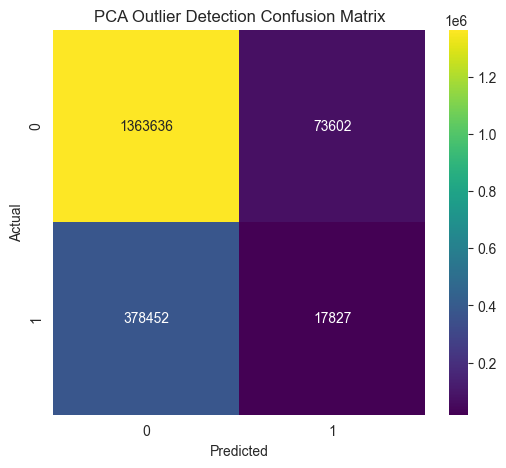

In [9]:
# 1) Fit PCA on the training data
# Retain enough components to preserve ~95% variance
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
pca.fit(train_data)

# 2) Reconstruct both training and test data
train_reconstructed = pca.inverse_transform(pca.transform(train_data))
test_reconstructed = pca.inverse_transform(pca.transform(test_data))

# 3) Compute reconstruction error (MSE) for each point
train_mse = np.mean((train_data - train_reconstructed) ** 2, axis=1)
test_mse = np.mean((test_data - test_reconstructed) ** 2, axis=1)

# 4) Set threshold based on training error (e.g., 95th percentile)
threshold = np.percentile(train_mse, 95)

# 5) Predict: if error > threshold → anomaly (1), else normal (0)
y_pred_pca = (test_mse > threshold).astype(int)
y_true = (test_label == 1).astype(int)

# 6) Classification metrics
print("PCA-based Outlier Detection Report:")
print(classification_report(y_true, y_pred_pca, digits=4))

# 7) Confusion matrix with seaborn
cm_pca = confusion_matrix(y_true, y_pred_pca)
plt.figure(figsize=(6,5))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='viridis',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('PCA Outlier Detection Confusion Matrix')
plt.show()